In [4]:
from beakerx.object import beakerx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [5]:
df = pd.read_csv("Data/mnist_train.csv")
y = df.label
x = df.drop("label", axis=1)
x = x.values.reshape(60000,28,28)

In [6]:
def scale(X, x_min=0, x_max=1):
    nom = (X-X.min())*(x_max-x_min)
    denom = X.max() - X.min()
    denom = denom + (denom is 0)
    return x_min + nom/denom

In [7]:
def one_hot_enc(y):
    b = np.zeros(y.size, y.max()+1)
    b[np.arange(y.size), y] = 1
    return b

In [8]:
x = scale(x)

In [9]:
enc = OneHotEncoder()
y = enc.fit_transform(y.values.reshape(-1,1)).toarray()

In [10]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [248]:
class Dense:
    def __init__(self, h_layers, n_outputs, img_rows, img_cols, act_funcs=[]):
        self.img_size = img_rows * img_cols
        # Done this way for clarity of user
        self.h_layers = h_layers.append(n_outputs)
        self.n_layers = len(h_layers)
        if act_funcs:
            self.act_funcs = []
            for act_func in act_funcs:
                if act_func == "relu":
                    self.act_funcs.append(self.relu)
                elif act_func == "sigmoid":
                    self.act_funcs.append(self.sigmoid)
                elif act_func == "sofmax":
                    self.act_funcs.append(self.softmax)
        else:
            self.act_funcs = [self.relu for _ in range(self.n_layers)]
            self.act_funcs[-1] = self.sigmoid
        act_func_dict = {self.relu: self.relu_prime,
                         self.sigmoid: self.sigmoid_prime, self.softmax: self.softmax_prime}
        self.act_funcs_prime = []
        for func in self.act_funcs:
            self.act_funcs_prime.append(act_func_dict[func])
        assert len(self.act_funcs) == self.n_layers

        # initialize weights with std. deviation that divides the random initializations by the sqrt of the number of inputs / 2
        # see cs231n Andrej Karpathy time-stamp 49:00 https://youtu.be/gYpoJMlgyXA?t=2942
        self.weights = [np.random.randn(
            self.img_size, h_layers[0]) / np.sqrt(self.img_size/2)]
        for i in range(self.n_layers-1):
            self.weights.append(np.random.randn(
                h_layers[i], h_layers[i+1]) / np.sqrt(h_layers[i] / 2))
        self.weights = np.array(self.weights)
        self.biases = np.array([np.random.randn(y) for y in h_layers])
        self.train_error = []

    def forward(self, inp, train=False):
        zipped = list(zip(self.biases, self.weights))
        if train:
            z = []
            a = [inp]
            for i in range(self.n_layers):
                b, w = zipped[i]
                inp = np.dot(inp, w) + b
                z.append(inp)
                inp = self.act_funcs[i](inp)
                a.append(inp)
            return a, z
        else:
            for i in range(self.n_layers):
                b, w = zipped[i]
                inp = self.act_funcs[i](np.dot(inp, w) + b)
            return inp

    def train(self, data, labels, epochs=500, batch_size=10, lr=.01):
        self.data = data
        self.labels = labels
        self.batch_error = []

        # TODO feed each image and track avg error. Compute gradient and backprop.

        for _ in range(epochs):
            x_batch, y_batch = self._get_batch(batch_size)
            batch_d_b = []
            batch_d_w = []
            for img, label in zip(x_batch, y_batch):
                a, z = self.forward(img, train=True)
                img_d_b = []
                img_d_w = []

                # TODO Change the loss function (really only affects the outcome in the computed gradient)
                loss = a[-1] - label
                self.batch_error.append(loss.mean())

                # set the final activ. grad. to deriv of loss function evaluated with activation of final layer == result of network
                d_a = (a[-1] - label) #* 2
                d_z = 0  # derivaties for current z_nodes
                for i in range(1, len(z)+1):
                    # d_a[-1]
                    # evaluate the derivative of z_nodes using the derivative of the activ. func used, evaluated at zL, and mult. by the leading grad, because of chain rule, that is stored at d_a[i]
                    d_z = self.act_funcs_prime[-i](z[-i]) * d_a

                    # The grad. of biases is just that of z_nodes
                    img_d_b.append(d_z)
                    # TODO There probably is a numpy operation that could replace this for loop
                    layer_d = []
                    for d_l in a[-i-1]:
                        layer_d.append(np.array(d_l * d_z))
                    img_d_w.append(np.array(layer_d))
                    d_a = np.dot(d_z, self.weights[-i].T)
                batch_d_b.append(img_d_b)
                batch_d_w.append(np.array(img_d_w))

            batch_d_w = np.array(batch_d_w).mean(axis=0) * .1
            batch_d_b = np.array(batch_d_b).mean(axis=0) * .1

            self.weights = self.weights - batch_d_w[::-1]
            self.biases = self.biases - batch_d_b[::-1]

            self.train_error.append(np.array(self.batch_error).mean())

    def _get_batch(self, batch_size):
        indices = np.random.randint(len(self.data), size=batch_size)
        #indices = [231]
        return self.data[indices].reshape(batch_size, 784), self.labels[indices]

    def relu(self, inp):
        return np.maximum(inp,  0)

    def relu_prime(self, inp):
        inp[inp <= 0] = 0
        inp[inp > 0] = 1
        return inp

    def softmax(self, inp):
        return (np.e ** inp) / (sum(np.e ** inp))

    def softmax_prime(self, inp):
        pass

    def sigmoid(self, inp):
        return 1.0/(1.0+np.exp(-inp))

    def sigmoid_prime(self, inp):
        return self.sigmoid(inp) * (1 - self.sigmoid(inp))

In [249]:
temp = Dense([16,16], 10, 28, 28, ["relu", "relu", "sigmoid"])

In [250]:
temp.train(x, y, 500, 20)

The network predicted: 0
The answer was actually: 0
The result of that index was: 0.41449504632329087
[0.41449505 0.0242857  0.17854021 0.26731575 0.17014342 0.09082489
 0.12014888 0.00986197 0.06011107 0.0304166 ]


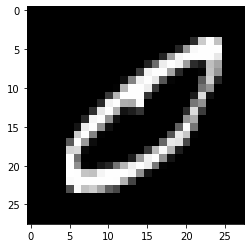

In [251]:
temp_i = 1029
temp_out = temp.forward(x[temp_i].reshape(784,))
print(f"The network predicted: {temp_out.argmax()}")
print(f"The answer was actually: {y[temp_i].argmax()}")
print(f"The result of that index was: {temp_out[temp_out.argmax()]}")
print(temp_out)
plt.imshow(x[temp_i], cmap="gray")

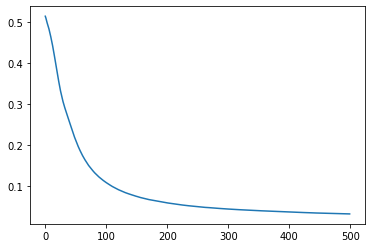

In [252]:
plt.plot(temp.train_error)

In [228]:
df_test = pd.read_csv("Data/mnist_test.csv")
y_test = df_test.label
x_test = df_test.drop("label", axis=1)
x_test = x_test.values.reshape(-1,28,28)

In [229]:
x_test = scale(x_test)
enc = OneHotEncoder()
y_test = enc.fit_transform(y_test.values.reshape(-1,1)).toarray()

In [253]:
temp.data = x_test
temp.labels = y_test
x_test_batch,y_test_batch = temp._get_batch(1000)

In [254]:
acc = []
for i in range(len(x_test_batch)):
    if temp.forward(x_test_batch[i]).argmax() == y_test_batch[i].argmax():
        acc.append(True)
    else:
        acc.append(False)


In [255]:
np.count_nonzero(np.array(acc))

677

In [49]:
test1 = np.array([1,2,3,4,5])

In [61]:
test2 = np.array([6,7,8,9])

In [62]:
test1

array([1, 2, 3, 4, 5])

In [63]:
test2

array([6, 7, 8, 9])

In [64]:
np.matmul(test1, test2)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 5)

In [65]:
test_w = np.random.randn(5,4)

In [66]:
np.dot(test1, test_w)

array([-5.94832296,  6.90994154, -1.82350211, -1.25931844])

In [67]:
test_w

array([[ 0.84416139,  0.07469629, -0.48060229, -1.31666615],
       [-0.84644705,  0.85671467,  1.69833576, -0.28980764],
       [ 1.89887086,  0.61815449, -0.75793266,  0.92701141],
       [-2.38114497, -1.18540353, -0.27029557, -0.58806487],
       [-0.25432459,  1.60179331, -0.27691821,  0.04163765]])

In [69]:
for i in test1:
    print(i * test2)

[6 7 8 9]
[12 14 16 18]
[18 21 24 27]
[24 28 32 36]
[30 35 40 45]
